# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [10]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 3.4 MB/s eta 0:00:00


In [24]:
# Import necessary libraries
import pandas as pd
import numpy as np
import shutil
import random
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Load dataset
Load preprocessed dataset and print basic details.

### Directory preparation

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import zipfile

# Replace 'path/to/your/zipped_folder.zip' with the actual path to your zipped folder in Google Drive.
zip_path = '/content/drive/MyDrive/opencampus_all_files/Rider1_preprocessed.zip'

# Extract the contents of the zip file to a specified directory.
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Rider1_preprocessed')
print(f"Successfully unzipped {zip_path} to /content/unzipped_folder")


Successfully unzipped /content/drive/MyDrive/opencampus_all_files/Rider1_preprocessed.zip to /content/unzipped_folder


In [27]:
source_dir = '/content/Rider1_preprocessed/content/content/Sport_xlsx/Rider1_preprocessed'
destination_dir = '/content/Rider1_preprocessed'

# Iterate through all files in the source directory
for filename in os.listdir(source_dir):
    source_path = os.path.join(source_dir, filename)
    destination_path = os.path.join(destination_dir, filename)

    # Check if it's a file (not a subdirectory)
    if os.path.isfile(source_path):
        # Move the file
        shutil.move(source_path, destination_path)

In [28]:
# Define the directory to clean
directory_to_clean = '/content/Rider1_preprocessed'

# Check if the directory exists
if os.path.exists(directory_to_clean):
    for filename in os.listdir(directory_to_clean):
        filepath = os.path.join(directory_to_clean, filename)
        try:
            if os.path.isdir(filepath):
                shutil.rmtree(filepath)  # Remove folders recursively
                print(f"Removed directory: {filepath}")
        except OSError as e:
            print(f"Error removing {filepath}: {e}")
else:
    print(f"Directory '{directory_to_clean}' not found.")

Removed directory: /content/Rider1_preprocessed/content


### Explore dataset

In [29]:
# Load example file
df = pd.read_excel('/content/Rider1_preprocessed/f1.xlsx')

# Show features
df.head()

,Latitude,Longitude,Elevation,Time,Distance
0,46.363649,14.112036,511.5,0,0.000000
1,46.363691,14.112026,511.0,1,4.731651
2,46.363778,14.112031,510.1,3,14.410085
3,46.363835,14.112023,509.7,5,20.775954
4,46.363888,14.112007,509.4,7,26.794638


In [30]:
# Print the range of all columns in the DataFrame
for col in df.columns:
    print(f"Column '{col}': Min = {df[col].min()}, Max = {df[col].max()}")

Column 'Latitude': Min = 46.338096, Max = 46.422636
Column 'Longitude': Min = 13.919303, Max = 14.112036
Column 'Elevation': Min = 480.8, Max = 1659.9
Column 'Time': Min = 0, Max = 20896
Column 'Distance': Min = 0.0, Max = 61367.54987900978


## Model Choice

In following notebook two models were implemented:
- Linear Regression
- Neural Network


## Feature engineering

#### Prepare pipeline

In [31]:
import pandas as pd
import math

# Define the function to calculate the angle
def calculate_angle(lat, lon, lat_prev, lon_prev, lat_next, lon_next):
    # Convert degrees to radians
    lat = math.radians(lat)
    lon = math.radians(lon)
    lat_prev = math.radians(lat_prev)
    lon_prev = math.radians(lon_prev)
    lat_next = math.radians(lat_next)
    lon_next = math.radians(lon_next)

    # Compute vectors in 3D Cartesian coordinates
    def to_cartesian(lat, lon):
        x = math.cos(lat) * math.cos(lon)
        y = math.cos(lat) * math.sin(lon)
        z = math.sin(lat)
        return (x, y, z)

    p1 = to_cartesian(lat_prev, lon_prev)
    p2 = to_cartesian(lat, lon)
    p3 = to_cartesian(lat_next, lon_next)

    # Calculate vectors
    v1 = (p1[0] - p2[0], p1[1] - p2[1], p1[2] - p2[2])
    v2 = (p3[0] - p2[0], p3[1] - p2[1], p3[2] - p2[2])

    # Compute magnitudes of vectors
    mag_v1 = math.sqrt(sum(v1[i]**2 for i in range(3)))
    mag_v2 = math.sqrt(sum(v2[i]**2 for i in range(3)))

    # Handle zero magnitude vectors
    if mag_v1 == 0 or mag_v2 == 0:
        return float('nan')  # Return NaN for undefined angle

    # Compute dot product
    dot_product = sum(v1[i] * v2[i] for i in range(3))

    # Calculate the angle using the dot product formula
    cos_theta = dot_product / (mag_v1 * mag_v2)
    angle = math.acos(max(-1, min(1, cos_theta)))  # Clamp to avoid numerical issues

    # Convert radians to degrees
    angle_degrees = math.degrees(angle)
    return angle_degrees

In [32]:
# Assuming 'df' is your DataFrame as defined in the previous code.
df['Latitude_prev'] = df['Latitude'].shift(1)
df['Longitude_prev'] = df['Longitude'].shift(1)
df['Elevation_prev'] = df['Elevation'].shift(1)
df['Latitude_next'] = df['Latitude'].shift(-1)
df['Longitude_next'] = df['Longitude'].shift(-1)
df['Elevation_next'] = df['Elevation'].shift(-1)

# Calculate speed based on distance and time differences
df['Time_prev'] = df['Time'].shift(1)
df['Time_next'] = df['Time'].shift(-1)
df['Distance_prev'] = df['Distance'].shift(1)
df['Distance_next'] = df['Distance'].shift(-1)

# Calculate time difference
df['Time_diff_prev'] = df['Time'] - df['Time_prev']
df['Time_diff_next'] = df['Time_next'] - df['Time']

# Calculate distance difference
df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

# Calculate speed (m/s)
df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

# Calculate slope
df['Slope_prev'] = (df['Elevation'] - df['Elevation_prev']) / (df['Distance'] - df['Distance_prev'])
df['Slope_next'] = (df['Elevation_next'] - df['Elevation']) / (df['Distance_next'] - df['Distance'])

# Handle potential divisions by zero
df['Slope_prev'] = df['Slope_prev'].fillna(0).replace([float('inf'), -float('inf')], 0)
df['Slope_next'] = df['Slope_next'].fillna(0).replace([float('inf'), -float('inf')], 0)

# Calculate angle between next and previous points
df['Angle'] = df.apply(
    lambda row: calculate_angle(
        row['Latitude'], row['Longitude'],
        row['Latitude_prev'], row['Longitude_prev'],
        row['Latitude_next'], row['Longitude_next']
    ), axis=1
)

# Calculate the sum of the slopes driven so far
df['Cumulative_Slope'] = df['Slope_prev'].cumsum()

# Rearrange columns
df = df[['Elevation', 'Slope_prev', 'Slope_next',  'Angle', 'Distance', 'Cumulative_Slope', 'Speed', 'Time']]

print(df.head())

   Elevation  Slope_prev  Slope_next       Angle   Distance  Cumulative_Slope  \
0      511.5    0.000000   -0.105671    0.000000   0.000000          0.000000   
1      511.0   -0.105671   -0.092990  168.398275   4.731651         -0.105671   
2      510.1   -0.092990   -0.062835  172.196854  14.410085         -0.198662   
3      509.7   -0.062835   -0.049845  173.764191  20.775954         -0.261497   
4      509.4   -0.049845   -0.064568  177.496029  26.794638         -0.311341   

      Speed  Time  
0       NaN     0  
1  4.803362     1  
2  4.011076     3  
3  3.096138     5  
4  3.053427     7  


#### Apply features

In [34]:
def move_random_files(source_dir, destination_dir, num_files, seed=None):
    # Set the random seed for reproducibility
    if seed is not None:
        random.seed(seed)

    # Get a list of all files in the source directory
    files = [f for f in os.listdir(source_dir) if os.path.isfile(os.path.join(source_dir, f))]

    # Check if there are enough files to move
    if len(files) < num_files:
        print(f"Not enough files in {source_dir}. Moving {len(files)} files.")
        num_files = len(files)

    # Randomly select files
    selected_files = random.sample(files, num_files)

    # Move the selected files to the destination directory
    for file in selected_files:
        source_path = os.path.join(source_dir, file)
        destination_path = os.path.join(destination_dir, file)
        try:
            shutil.move(source_path, destination_path)
            print(f"Moved {file} to {destination_dir}")
        except Exception as e:
            print(f"Error moving {file}: {e}")

# Example usage
source_directory = '/content/Rider1_preprocessed'
destination_directory = '/content/Rider1_test'
number_of_files = 10
seed = 123

# Create destination directory if it does not exist
if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

move_random_files(source_directory, destination_directory, number_of_files, seed)

Moved f241.xlsx to /content/Rider1_test
Moved f493.xlsx to /content/Rider1_test
Moved f479.xlsx to /content/Rider1_test
Moved f578.xlsx to /content/Rider1_test
Moved f665.xlsx to /content/Rider1_test
Moved f746.xlsx to /content/Rider1_test
Moved f234.xlsx to /content/Rider1_test
Moved f9.xlsx to /content/Rider1_test
Moved f349.xlsx to /content/Rider1_test
Moved f42.xlsx to /content/Rider1_test


In [35]:
# Directory containing the Excel files
directory = '/content/Rider1_preprocessed'

# Initialize an empty list to store DataFrames
dataframes = []

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.xlsx'):  # Process only .xlsx files
        filepath = os.path.join(directory, filename)

        # Read the Excel file into a DataFrame
        df = pd.read_excel(filepath)

        # Apply preprocessing
        df['Latitude_prev'] = df['Latitude'].shift(1)
        df['Longitude_prev'] = df['Longitude'].shift(1)
        df['Elevation_prev'] = df['Elevation'].shift(1)
        df['Latitude_next'] = df['Latitude'].shift(-1)
        df['Longitude_next'] = df['Longitude'].shift(-1)
        df['Elevation_next'] = df['Elevation'].shift(-1)

        # Calculate speed based on distance and time differences
        df['Time_prev'] = df['Time'].shift(1)
        df['Time_next'] = df['Time'].shift(-1)
        df['Distance_prev'] = df['Distance'].shift(1)
        df['Distance_next'] = df['Distance'].shift(-1)

        # Calculate time difference
        df['Time_diff_prev'] = df['Time'] - df['Time_prev']
        df['Time_diff_next'] = df['Time_next'] - df['Time']

        # Calculate distance difference
        df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
        df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

        # Calculate speed (m/s)
        df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

        # Calculate slope
        df['Slope_prev'] = (df['Elevation'] - df['Elevation_prev']) / (df['Distance'] - df['Distance_prev'])
        df['Slope_next'] = (df['Elevation_next'] - df['Elevation']) / (df['Distance_next'] - df['Distance'])

        # Handle potential divisions by zero
        df['Slope_prev'] = df['Slope_prev'].fillna(0).replace([float('inf'), -float('inf')], 0)
        df['Slope_next'] = df['Slope_next'].fillna(0).replace([float('inf'), -float('inf')], 0)

        # Calculate angle between next and previous points
        df['Angle'] = df.apply(
            lambda row: calculate_angle(
                row['Latitude'], row['Longitude'],
                row['Latitude_prev'], row['Longitude_prev'],
                row['Latitude_next'], row['Longitude_next']
            ), axis=1
        )

        # Calculate the sum of the slopes driven so far
        df['Cumulative_Slope'] = df['Slope_prev'].cumsum()

        # Rearrange columns
        df = df[['Elevation', 'Slope_prev', 'Slope_next',  'Angle', 'Distance', 'Cumulative_Slope', 'Speed', 'Time']]

        # Drop NaN values
        df = df.dropna()

        # Append the processed DataFrame to the list
        dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# Display the first few rows of the combined DataFrame
print(combined_df.head())


   Elevation  Slope_prev  Slope_next       Angle   Distance  Cumulative_Slope  \
0      339.3   -0.387829   -0.374170  167.666328   4.125526         -0.387829   
1      337.9   -0.374170   -0.050340  101.579280   7.867136         -0.762000   
2      337.7   -0.050340    0.062166  166.173799  11.840128         -0.812340   
3      337.9    0.062166   -0.268842  129.777120  15.057326         -0.750174   
4      336.7   -0.268842    0.385453   61.469629  19.520916         -1.019016   

      Speed  Time  
0  1.966784     3  
1  1.928650     4  
2  1.438038     7  
3  1.536158     9  
4  1.894202    12  


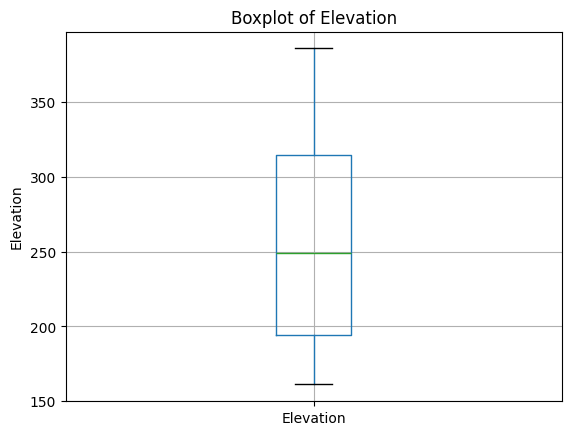

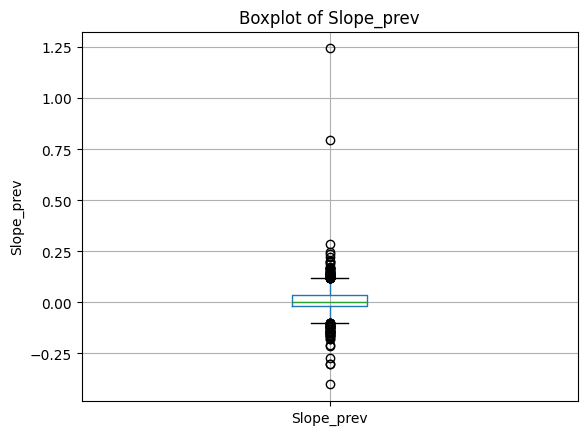

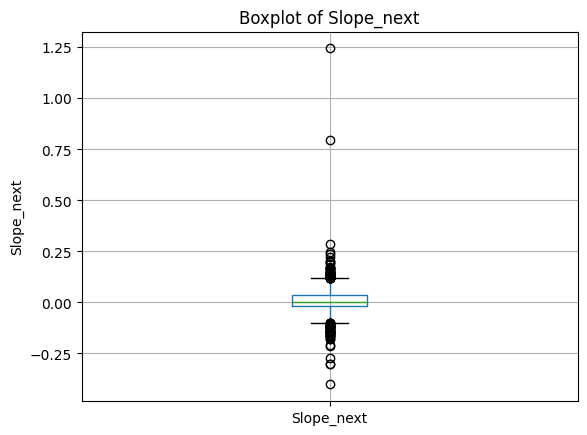

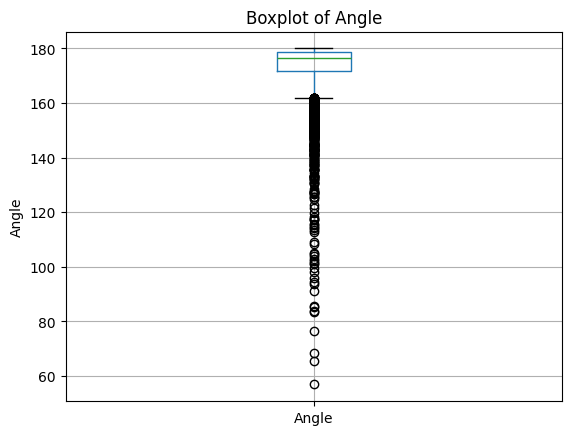

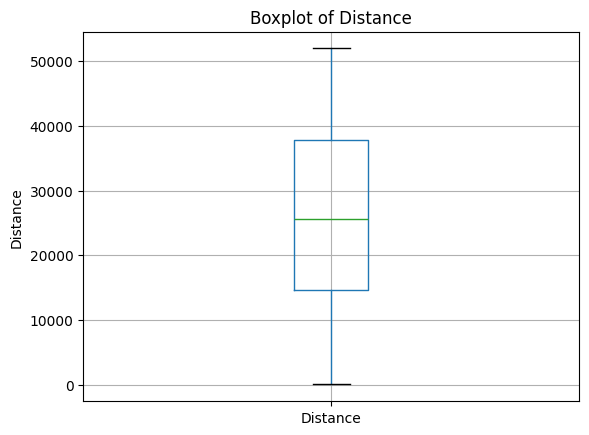

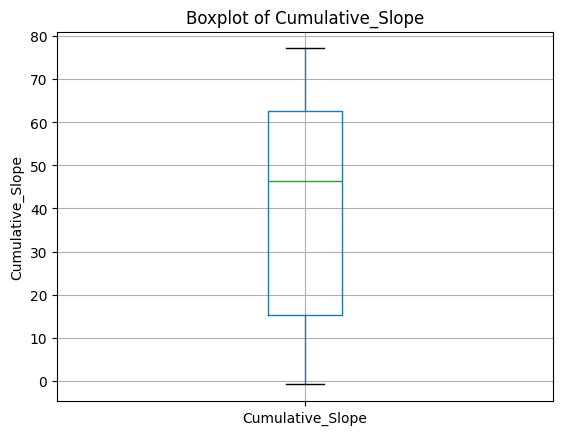

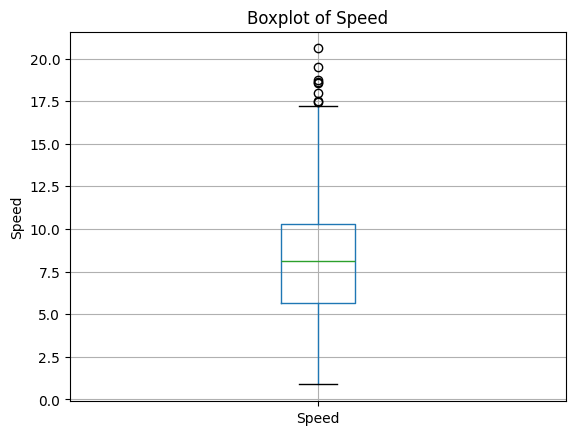

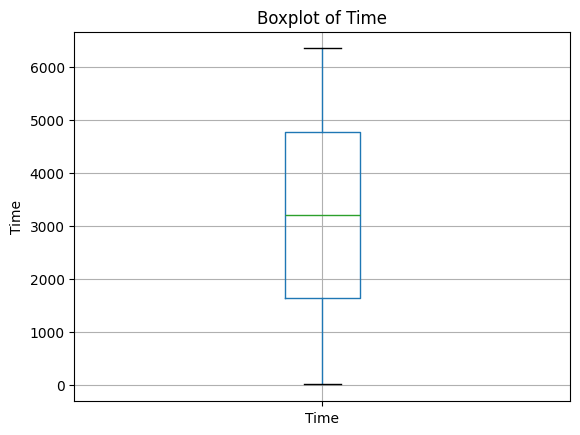

In [40]:
# prompt: Print boxplots of all variables in df

import matplotlib.pyplot as plt

# Create boxplots for all numerical columns
for column in combined_df.select_dtypes(include=np.number):
    plt.figure()  # Create a new figure for each boxplot
    df.boxplot(column=[column])
    plt.title(f'Boxplot of {column}')
    plt.ylabel(column)
    plt.show()

In [39]:
# prompt: Clean combined_df: Remove rows with negative elevation, remove slope higher than abs(1.0), remove speed > 75, write a summary how many rows were deleted and how many are left

# Original row count
original_row_count = len(combined_df)

# Remove rows with negative elevation
combined_df = combined_df[combined_df['Elevation'] >= 0]

# Remove rows with slope higher than abs(1.0)
combined_df = combined_df[combined_df['Slope_prev'].abs() <= 1.0]
combined_df = combined_df[combined_df['Slope_next'].abs() <= 1.0]

# Remove rows with speed > 75
combined_df = combined_df[combined_df['Speed'] <= 75]

# Calculate the number of deleted rows
deleted_rows = original_row_count - len(combined_df)

# Print summary
print(f"Original number of rows: {original_row_count}")
print(f"Number of deleted rows: {deleted_rows}")
print(f"Remaining number of rows: {len(combined_df)}")

Original number of rows: 4405857
Number of deleted rows: 65935
Remaining number of rows: 4339922


In [41]:
# Save the combined DataFrame to a file (optional)
combined_df.to_csv('/content/combined_data_r1.csv', index=False)

## Feature Selection

Selected features describes terrain characteristics and cumulative statistics of current track.

In [42]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('/content/combined_data_r1.csv')

In [43]:
# Print the range of all columns in the DataFrame
for col in df.columns:
    print(f"Column '{col}': Min = {df[col].min()}, Max = {df[col].max()}")

Column 'Elevation': Min = 0.0, Max = 2039.3
Column 'Slope_prev': Min = -0.999711394712658, Max = 0.9997661148846212
Column 'Slope_next': Min = -0.999711394712658, Max = 0.9992483118919666
Column 'Angle': Min = 0.0, Max = 180.0
Column 'Distance': Min = 0.076682802713683, Max = 212508.5813685636
Column 'Cumulative_Slope': Min = -506.9014171839586, Max = 1767.6021509480772
Column 'Speed': Min = 5.108334138289554e-05, Max = 74.82260024165225
Column 'Time': Min = 1, Max = 32085


In [44]:
# Feature selection
# Example: Selecting only two features for a simple baseline model
X = df[['Elevation', 'Slope_prev', 'Slope_next', 'Angle', 'Distance', 'Cumulative_Slope']] # Decide slope or elev
y = df['Speed']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [45]:
# Size of datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (3471937, 6)
X_test shape: (867985, 6)
y_train shape: (3471937,)
y_test shape: (867985,)


## Implementation





#### Baseline model 1 - Linear Regression

In [46]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.5920189463430114


#### Baseline model 2 - Simple Neural Network

Epoch 1/10
108499/108499 [==============================] - 192s 2ms/step - loss: 6.0789 - mae: 1.7442 - val_loss: 5.7458 - val_mae: 1.6942
Epoch 2/10
108499/108499 [==============================] - 194s 2ms/step - loss: 5.6218 - mae: 1.6576 - val_loss: 5.5403 - val_mae: 1.6437
Epoch 3/10
108499/108499 [==============================] - 186s 2ms/step - loss: 5.5015 - mae: 1.6314 - val_loss: 5.5230 - val_mae: 1.6315
Epoch 4/10
108499/108499 [==============================] - 190s 2ms/step - loss: 5.4364 - mae: 1.6188 - val_loss: 5.3874 - val_mae: 1.6145
Epoch 5/10
108499/108499 [==============================] - 192s 2ms/step - loss: 5.3874 - mae: 1.6085 - val_loss: 5.3517 - val_mae: 1.6034
Epoch 6/10
108499/108499 [==============================] - 190s 2ms/step - loss: 5.3439 - mae: 1.5992 - val_loss: 5.3037 - val_mae: 1.5924
Epoch 7/10
108499/108499 [==============================] - 194s 2ms/step - loss: 5.3140 - mae: 1.5931 - val_loss: 5.3316 - val_mae: 1.5979
Epoch 8/10
108499/10

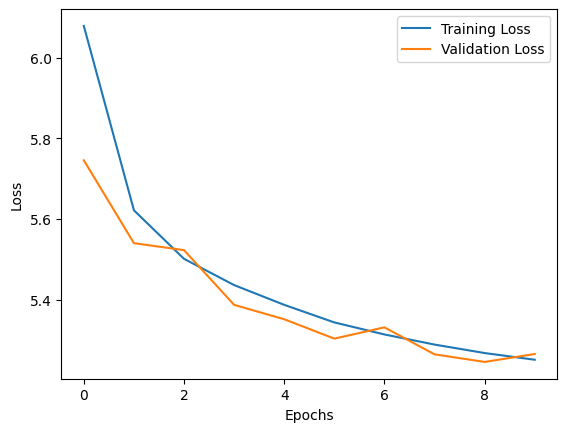

In [47]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
    Dense(32, activation='relu'),  # Second hidden layer
    Dense(1)  # Output layer (no activation since we're doing regression)
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Optionally, plot the training history (e.g., loss or MAE over epochs)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluation

Evaluation based on loss and MAE.


#### Preprocess test file

In [67]:
# Prepare test file
df = pd.read_excel('/content/Rider1_test/f234.xlsx')

# Assuming 'df' is your DataFrame as defined in the previous code.
df['Latitude_prev'] = df['Latitude'].shift(1)
df['Longitude_prev'] = df['Longitude'].shift(1)
df['Elevation_prev'] = df['Elevation'].shift(1)
df['Latitude_next'] = df['Latitude'].shift(-1)
df['Longitude_next'] = df['Longitude'].shift(-1)
df['Elevation_next'] = df['Elevation'].shift(-1)

# Calculate speed based on distance and time differences
df['Time_prev'] = df['Time'].shift(1)
df['Time_next'] = df['Time'].shift(-1)
df['Distance_prev'] = df['Distance'].shift(1)
df['Distance_next'] = df['Distance'].shift(-1)

# Calculate time difference
df['Time_diff_prev'] = df['Time'] - df['Time_prev']
df['Time_diff_next'] = df['Time_next'] - df['Time']

# Calculate distance difference
df['Distance_diff_prev'] = df['Distance'] - df['Distance_prev']
df['Distance_diff_next'] = df['Distance_next'] - df['Distance']

# Calculate speed (m/s)
df['Speed'] = (df['Distance_diff_next'] + df['Distance_diff_prev']) / (df['Time_diff_next'] + df['Time_diff_prev'])

# Calculate slope
df['Slope_prev'] = (df['Elevation'] - df['Elevation_prev']) / (df['Distance'] - df['Distance_prev'])
df['Slope_next'] = (df['Elevation_next'] - df['Elevation']) / (df['Distance_next'] - df['Distance'])

# Handle potential divisions by zero
df['Slope_prev'] = df['Slope_prev'].fillna(0).replace([float('inf'), -float('inf')], 0)
df['Slope_next'] = df['Slope_next'].fillna(0).replace([float('inf'), -float('inf')], 0)

# Calculate angle between next and previous points
df['Angle'] = df.apply(
    lambda row: calculate_angle(
        row['Latitude'], row['Longitude'],
        row['Latitude_prev'], row['Longitude_prev'],
        row['Latitude_next'], row['Longitude_next']
    ), axis=1
)

# Calculate the sum of the slopes driven so far
df['Cumulative_Slope'] = df['Slope_prev'].cumsum()

# Drop NaN values
df = df.dropna()
df = df.reset_index(drop=True)

# Rearrange columns
df = df[['Elevation', 'Slope_prev', 'Slope_next',  'Angle', 'Distance', 'Cumulative_Slope', 'Speed', 'Time']]

print(df.head())

   Elevation  Slope_prev  Slope_next       Angle   Distance  Cumulative_Slope  \
0      468.4   -0.212480   -0.095519  178.010424   0.470633         -0.212480   
1      468.3   -0.095519   -0.105583  162.415455   1.517546         -0.307999   
2      468.2   -0.105583   -0.029522   27.899756   2.464669         -0.413582   
3      468.1   -0.029522   -0.076752  159.951057   5.851968         -0.443104   
4      467.7   -0.076752    0.111864  114.903001  11.063557         -0.519856   

      Speed  Time  
0  0.758773     1  
1  0.664679     2  
2  0.722404     4  
3  1.228413     8  
4  1.762544    11  


In [68]:
# Feature selection
# Example: Selecting only two features for a simple baseline model
real_time = df['Time']
X = df[['Elevation', 'Slope_prev', 'Slope_next',  'Angle', 'Distance', 'Cumulative_Slope']] # Cumulative slope
y = df['Speed']


#### Evaluation 1 - Linear Regression

In [62]:
# Make predictions on the new data
y_pred = lr_model.predict(X)

# Add the predicted values as a new column 'Speed_pred' in the original DataFrame
df['Speed_pred'] = y_pred

# Optionally, check the first few rows to verify the new column is added correctly
print(df.head())


   Elevation  Slope_prev  Slope_next       Angle   Distance  Cumulative_Slope  \
0      468.4   -0.212480   -0.095519  178.010424   0.470633         -0.212480   
1      468.3   -0.095519   -0.105583  162.415455   1.517546         -0.307999   
2      468.2   -0.105583   -0.029522   27.899756   2.464669         -0.413582   
3      468.1   -0.029522   -0.076752  159.951057   5.851968         -0.443104   
4      467.7   -0.076752    0.111864  114.903001  11.063557         -0.519856   

      Speed  Time  Speed_pred  
0  0.758773     1    8.749079  
1  0.664679     2    7.334696  
2  0.722404     4   -0.662097  
3  1.228413     8    6.726298  
4  1.762544    11    3.451213  


In [63]:
# prompt: Calculate MAE between df['Speed_pred'] and df['Speed']

mae = mean_absolute_error(df['Speed'], df['Speed_pred'])
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 3.009770589288637


#### Evaluation 2 - Neural Network

In [69]:
# Normalize the new data using the same scaler fitted on the training data
X_new_scaled = scaler.transform(X)

# Make predictions on the new data
y_pred = model.predict(X_new_scaled)

# Add the predicted values as a new column 'Speed_pred' in the original DataFrame
df['Speed_pred'] = y_pred

# Optionally, check the first few rows to verify the new column is added correctly
print(df.head())


196/196 [==============================] - 0s 1ms/step
   Elevation  Slope_prev  Slope_next       Angle   Distance  Cumulative_Slope  \
0      468.4   -0.212480   -0.095519  178.010424   0.470633         -0.212480   
1      468.3   -0.095519   -0.105583  162.415455   1.517546         -0.307999   
2      468.2   -0.105583   -0.029522   27.899756   2.464669         -0.413582   
3      468.1   -0.029522   -0.076752  159.951057   5.851968         -0.443104   
4      467.7   -0.076752    0.111864  114.903001  11.063557         -0.519856   

      Speed  Time  Speed_pred  
0  0.758773     1    4.360478  
1  0.664679     2    4.786289  
2  0.722404     4   11.243628  
3  1.228413     8    6.860114  
4  1.762544    11    2.149767  


In [70]:
# prompt: Calculate MAE between df['Speed_pred'] and df['Speed']

mae = mean_absolute_error(df['Speed'], df['Speed_pred'])
print(f"Mean Absolute Error: {mae}")


Mean Absolute Error: 2.6399381797313697


In [71]:
df.head()

,Elevation,Slope_prev,Slope_next,Angle,Distance,Cumulative_Slope,Speed,Time,Speed_pred
0,468.4,-0.212480,-0.095519,178.010424,0.470633,-0.212480,0.758773,1,4.360478
1,468.3,-0.095519,-0.105583,162.415455,1.517546,-0.307999,0.664679,2,4.786289
2,468.2,-0.105583,-0.029522,27.899756,2.464669,-0.413582,0.722404,4,11.243628
3,468.1,-0.029522,-0.076752,159.951057,5.851968,-0.443104,1.228413,8,6.860114
4,467.7,-0.076752,0.111864,114.903001,11.063557,-0.519856,1.762544,11,2.149767


## Evaluate track length in seconds

### Example code

In [ ]:
import pandas as pd
import numpy as np

# Data
data = {
    'Speed': [np.nan, 4.606892, 5.372097, 6.147122, 6.584172],
    'Distance': [0.0, 4.111612, 9.213784, 14.855806, 21.508028]
}
df = pd.DataFrame(data)

# Initialize Time column
df['Time'] = 0.0

# Compute Time intelligently
for i in range(1, len(df)):
    if pd.notna(df.loc[i, 'Speed']):
        df.loc[i, 'Time'] = df.loc[i - 1, 'Time'] + (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed']

print(df)

      Speed   Distance      Time
0       NaN   0.000000  0.000000
1  4.606892   4.111612  0.892492
2  5.372097   9.213784  1.842246
3  6.147122  14.855806  2.760077
4  6.584172  21.508028  3.770413


### Implementation on test route

In [72]:
# Initialize Time column
df['pred_time'] = 0.0

# Compute predicted time
for i in range(2, len(df)):
  if pd.notna(df.loc[i, 'Speed_pred']):
    if df.loc[i, 'Speed_pred'] != 0:
      df.loc[i, 'pred_time'] = df.loc[i - 1, 'pred_time'] + (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed_pred']
    else:
      df.loc[i, 'pred_time'] = df.loc[i - 1, 'pred_time']

print(df)

      Elevation  Slope_prev  Slope_next       Angle      Distance  \
0         468.4   -0.212480   -0.095519  178.010424      0.470633   
1         468.3   -0.095519   -0.105583  162.415455      1.517546   
2         468.2   -0.105583   -0.029522   27.899756      2.464669   
3         468.1   -0.029522   -0.076752  159.951057      5.851968   
4         467.7   -0.076752    0.111864  114.903001     11.063557   
...         ...         ...         ...         ...           ...   
6255      476.7   -0.171718   -0.082984  179.143224  51250.040526   
6256      475.2   -0.082984   -0.021847  179.209099  51268.116334   
6257      474.8   -0.021847   -0.064105  178.353241  51286.425116   
6258      473.6   -0.064105   -0.084127  178.576724  51305.144334   
6259      472.0   -0.084127   -0.021320  179.481785  51324.163149   

      Cumulative_Slope     Speed   Time  Speed_pred    pred_time  
0            -0.212480  0.758773      1    4.360478     0.000000  
1            -0.307999  0.664679     

In [73]:
df[['Speed', 'Speed_pred', 'Time', 'pred_time']]

,Speed,Speed_pred,Time,pred_time
0,0.758773,4.360478,1,0.000000
1,0.664679,4.786289,2,0.000000
2,0.722404,11.243628,4,0.084237
3,1.228413,6.860114,8,0.578004
4,1.762544,2.149767,11,3.002261
...,...,...,...,...
6255,9.032163,9.756586,19523,9927.395049
6256,9.096147,11.485308,19525,9928.968869
6257,9.257000,11.745477,19527,9930.527663
6258,9.434508,11.751875,19529,9932.120534
